# Traffic Sign Classificator
En este ejercicio vamos a implementar una red convolucional para la clasificación de señales de tráfico, dichas señales han sido previamente extraidas mediante un software de tracking.

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras import regularizers 
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import cv2
from PIL import Image
import os

Using TensorFlow backend.


La siguinte función carga los datos datos de entrenamiento, son 39209 imágenes en 43 carpetas diferentes, una por cada tipo de señal. Como todas las imagenes tienen el mismo tamaño, será necesario pasar por parámetro la dimensión a la que queremos que estas se adapten. También pasamos por parámetro el número de clases.

In [3]:
def load_train(folders,size):
    X=[]
    Y=[]
    for i in range(folders) :
        path = "D:/santi/Documents/MyLearningPath/traffic_sign/data/Train/{0}/".format(i)
        folder=os.listdir(path)
        for img in folder:
            try:
                image=cv2.imread(path+img)
                image_RGB = Image.fromarray(image, 'RGB')
                resized_image = image_RGB.resize((size[0], size[1]))
                X.append(np.array(resized_image))
                Y.append(i)
            except AttributeError:
                print("Error loading picture ", img)
    return np.asarray(X),np.asarray(Y)

La función load_test() carga los datos de prueba. A diferencia de load_train(), la clase de cada foto se extrae de un archivo csv de con los metadatos.

In [4]:
def load_test(size):
    Y=pd.read_csv("D:/santi/Documents/MyLearningPath/traffic_sign/data/Test.csv")
    labels=np.array(Y['Path'])
    Y=Y['ClassId'].values
    X=[]
    for f in labels:
        try:
            image=cv2.imread('D:/santi/Documents/MyLearningPath/traffic_sign/data/Test/'+f.replace('Test/', ''))
            image_RGB = Image.fromarray(image, 'RGB')
            resized_image = image_RGB.resize((size[0], size[1]))
            X.append(np.array(resized_image))
        except AttributeError:
                print("Error loading picture ", img)
    return np.asarray(X),np.asarray(Y)


Cargamos los datos de entrenamiento, como están ordenados por clases, los mezclamos aleatoriamente. Normalizamos los datos dividiendo cada datos entre 255 y reservamos un 20% de las imágenes para el set de validación.

In [5]:
X,Y=load_train(43,[30,30])
#Barajamos los datos
s=np.arange(X.shape[0])
np.random.seed(43)
np.random.shuffle(s)
X=X[s]
Y=Y[s]
#Spliting the images 
(X_train,X_val)=X[(int)(0.2*len(Y)):],X[:(int)(0.2*len(Y))]
X_train = X_train.astype('float32')/255 #Train normalization 
X_val = X_val.astype('float32')/255 #Test normalization
(y_train,y_val)=Y[(int)(0.2*len(Y)):],Y[:(int)(0.2*len(Y))]
#hot encoding for the train and validation set
from keras.utils import to_categorical
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

En la siguiente función implementamos la arquitectura de la CNN:
* Capa convolucional: 32 filtros de tamaño 5*5, stride de 1 y valid para el padding.
* Capa convolucional: 64 filtros de tamaño 3*3, stride de 1 y valid para el padding.
* Capa maxpooling: tamño de 2,2 con stride de 1 y valid para el padding.
* Capa de dropout del 25%: descartamos el 25% de los datos aleatoriamente para prevenir overfitting.
* Capa convolucional: 64 filtros de tamaño 3*3, stride de 1 y valid para el padding.
* Capa maxpooling: tamño de 2,2 con stride de 1 y valid para el padding.
* Capa de dropout del 25%.
* Capa fully-connected.
* Capa de 256 neuronas.
* Capa de dropout del 50%.
* Capa de salida, 43 neuronas con la función softmax


In [6]:
def build_model():
    #Model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=5,padding='valid', strides=1, activation='relu', input_shape=(30,30,3)))
    model.add(Conv2D(64, kernel_size=3,padding='valid', strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=1, padding='valid', data_format=None))#model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3,padding='same', strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=1, padding='valid', data_format=None))#model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))#,kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(rate=0.5))
    model.add(Dense(43, activation='softmax'))
    return model

Compilamos y entranameos el modelo con la funcion de error cross-entropía y optimizador adam.

Train on 31368 samples, validate on 7841 samples
Epoch 1/5
31368/31368 [==============================] - 61s 2ms/step - loss: 1.1448 - accuracy: 0.6764 - val_loss: 0.1352 - val_accuracy: 0.9682
Epoch 2/5
31368/31368 [==============================] - 52s 2ms/step - loss: 0.2625 - accuracy: 0.9192 - val_loss: 0.0675 - val_accuracy: 0.9824
Epoch 3/5
31368/31368 [==============================] - 50s 2ms/step - loss: 0.1602 - accuracy: 0.9514 - val_loss: 0.0429 - val_accuracy: 0.9889
Epoch 4/5
31368/31368 [==============================] - 51s 2ms/step - loss: 0.1245 - accuracy: 0.9615 - val_loss: 0.0376 - val_accuracy: 0.9911
Epoch 5/5
31368/31368 [==============================] - 51s 2ms/step - loss: 0.0984 - accuracy: 0.9705 - val_loss: 0.0327 - val_accuracy: 0.9922


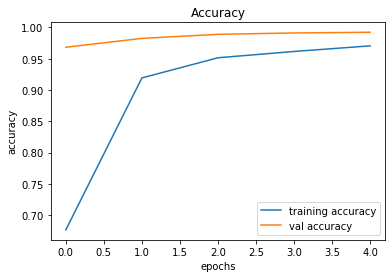

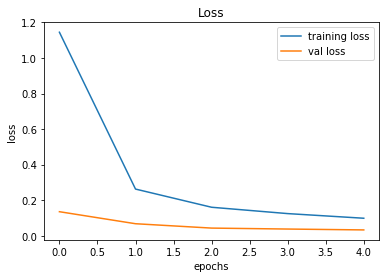

In [7]:
#Compilation of the model
model=build_model()
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)
#entrenamos el modelo 15 iteraciones
epochs = 5
history=model.fit(X_train, y_train, batch_size=32, epochs=epochs,validation_data=(X_val, y_val))
#ploting the loss function in train and test
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Probamos la eficacia del modelo con los datos de prueba.

In [8]:
X_test,Y_test=load_test([30,30])
X_test = X_test.astype('float32')/255 
y_pred = model.predict_classes(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test, y_pred))

0.9691211401425178
